# Question 1

In [2]:
%matplotlib inline

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def dRdt(R, S, X, k1 = 2, k2 = 2):
    return k1 * S - k2 * X * R

def dXdt(X, S, R, k3 = 1, k4 = 1):
    return k3 * S - k4 * X

def equilibriumX(k3, k4, S):
    return k3 * S / k4

def equilibriumR(k1, k2, S, X):
    return (k1 * S) / (k2 * X)

def system(y, t, S, k1, k2, k3, k4):
    R, X = y
    
    return np.array([dRdt(R, S, X, k1, k2), dXdt(X, S, R, k3, k4)])

In [4]:
k1 = k2 = 2
k3 = k4 = 1

### 1a

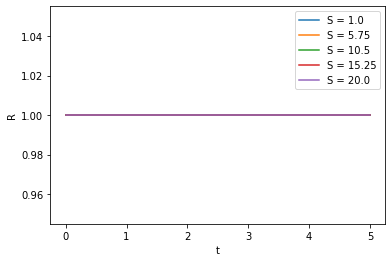

In [21]:
t_values = np.linspace(0, 5, 50)

for S in np.linspace(1, 20, 5):
    X = equilibriumX(k3, k4, S)
    R = equilibriumR(k1, k2, S, X)
    
    rate = odeint(system, y0 = [R, X], t = t_values, args = (S, k1, k2, k3, k4)).transpose()[0]
    plt.plot(t_values, rate, label=f"S = {S}")
    
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.show()

### 1b

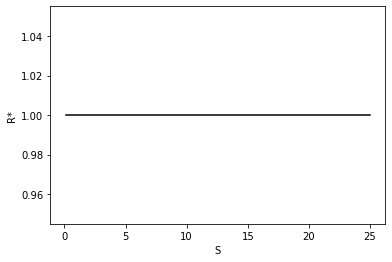

In [22]:
S_values = np.linspace(0.1, 25, 50)
R_values = []

for S in S_values:
    X = equilibriumX(k3, k4, S)    
    R_values.append(equilibriumR(k1, k2, S, X))
    
plt.plot(S_values, R_values, 'k')
plt.xlabel("S")
plt.ylabel("R*")
plt.show()

### 1c

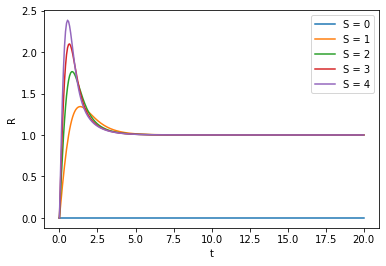

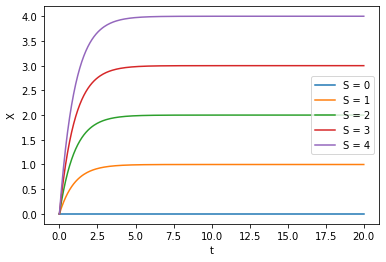

In [23]:
t_values = np.linspace(0, 20, 300)
S_values = range(5)
concentrations = []

for S in S_values:
    concentrations.append(odeint(system, y0 = [0, 0], t = t_values, args = (S, k1, k2, k3, k4)).transpose())

plt.plot(t_values, np.array(concentrations)[:, 0].T, label=f"S = {S}")
plt.xlabel("t")
plt.ylabel("R")
plt.legend([f"S = {S}" for S in S_values])
plt.show()

plt.plot(t_values, np.array(concentrations)[:, 1].T, label=f"S = {S}")
plt.xlabel("t")
plt.ylabel("X")
plt.legend([f"S = {S}" for S in S_values])
plt.show()

In [5]:
from scipy.optimize import fsolve, root

def G(u, v, J, K):
    # Goldbeter-Koshland function
    
    return (2*u*K) / (v - u + v*J + u*K + ((v - u + v*J + u*K)**2 - 4*(v - u)*u*K)**0.5)

class Feedback:
    def rate_different_S(self, S_values, t_max):
        plt.figure()
        t_values = np.linspace(0, t_max, 100)

        for S in S_values:
            R0 = 1 #self.equilibriumR(S)

            rate = odeint(self.dRdt, y0 = R0, t = t_values, args = (S,)).transpose()[0]
            plt.plot(t_values, rate, label=f"S = {S}")
        
        plt.xlabel("t")
        plt.ylabel("R")
        plt.legend()
        plt.title(type(self).__name__)   
        plt.show()
        
    def dR_different_S(self, S_values, R_values=np.linspace(0,50, 5000)):
        plt.figure()
        for S in S_values:
            plt.plot(R_values, self.dRdt(R_values, [0, 0], S), label=f"S = {S}")
        plt.xlabel("R")
        plt.ylabel("dRdt")
        plt.legend()
        plt.title(type(self).__name__)    
        plt.show()
        
    def signal_response_curve(self, S_values, R_values=np.linspace(0, 50, 5000)):
        plt.figure()
        roots = []
        
        for S in S_values:
            dRs = self.dRdt(R_values, 0, S)
            temp = []
            
            for i in range(1, len(dRs)):    
                if dRs[i] * dRs[i-1] < 0:
                    temp.append((R_values[i]+R_values[i-1])/2)
                    
            roots.append(temp)
        
        x = []
        y = []
        for i in range(len(S_values)):
            x.extend([S_values[i]] * len(roots[i]))
            y.extend(roots[i])
        
        plt.xlabel("S")
        plt.ylabel(r"R*")
        plt.title(type(self).__name__)   
        plt.scatter(x, y, s=0.1)
        plt.show()
        
class Homeostasis(Feedback):
    def __init__(self, k0=1,k2=1,k3=0.5,k4=1,J3=0.01,J4=0.01):
        self.k0, self.k2, self.k3, self.k4, self.J3, self.J4 = k0, k2, k3, k4, J3, J4
        
    def E(self, R):
        return G(self.k3, self.k4*R, self.J3, self.J4)
    
    def dRdt(self, R, t, S):
        return self.k0*self.E(R) - self.k2*S*R

class MutualInhibition(Feedback):
    def __init__(self, k0=0,k1=1,k2=0.05,k2prime=0.5,k3=1,k4=0.2,J3=0.05,J4=0.05):  
        self.k0, self.k1, self.k2, self.k2prime, self.k3, self.k4, self.J3, self.J4 = k0, k1, k2, k2prime, k3, k4, J3, J4
        
    def E(self, R):
        return G(self.k3, self.k4*R, self.J3, self.J4)
    
    def dRdt(self, R, t, S):
        return self.k0 + self.k1*S - self.k2*R - self.k2prime*self.E(R)*R

class MutualActivation(Feedback):
    def __init__(self, k0=0.4,k1=0.01,k2=1,k3=1,k4=0.2,J3=0.05,J4=0.05):
        self.k0, self.k1, self.k2, self.k3, self.k4, self.J3, self.J4 = k0, k1, k2, k3, k4, J3, J4
    
    def E(self, R):
        return G(self.k3*R, self.k4, self.J3, self.J4)
    
    def dRdt(self, R, t, S):
        return self.k0*self.E(R) + self.k1*S - self.k2*R

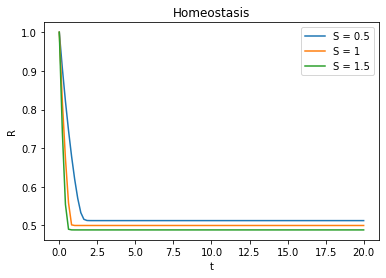

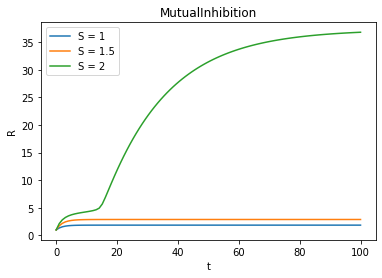

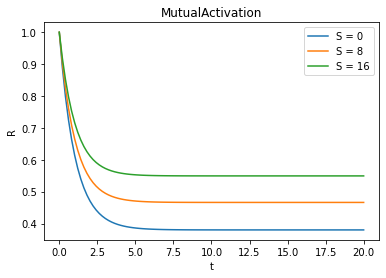

In [25]:
Homeostasis().rate_different_S((0.5,1,1.5), 20)
MutualInhibition().rate_different_S((1,1.5,2), 100)
MutualActivation().rate_different_S((0,8,16), 20)

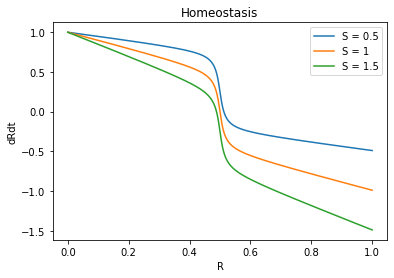

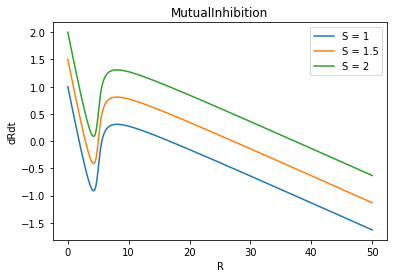

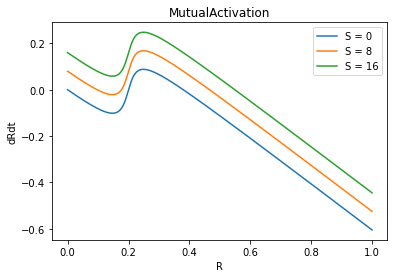

In [26]:
Homeostasis().dR_different_S((0.5,1,1.5), R_values=np.linspace(0,1, 5000))
MutualInhibition().dR_different_S((1,1.5,2), R_values=np.linspace(0,50, 5000))
MutualActivation().dR_different_S((0,8,16), R_values=np.linspace(0,1, 5000))

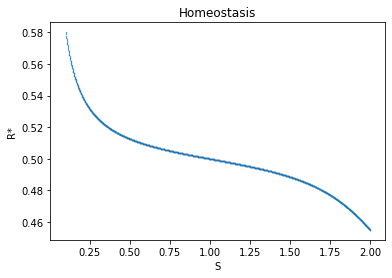

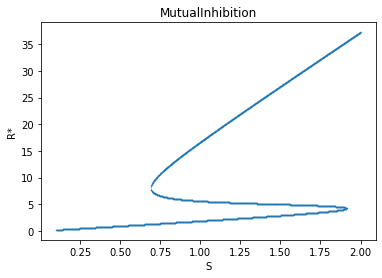

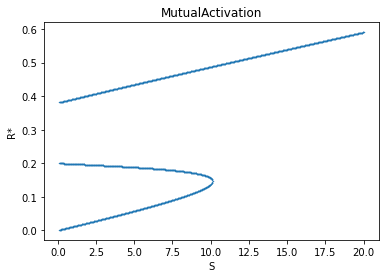

In [28]:
R_precision = 5000
S_precision = 2000

Homeostasis().signal_response_curve(np.linspace(0.1, 2, S_precision), R_values=np.linspace(0.45, 0.6, R_precision))
MutualInhibition().signal_response_curve(np.linspace(0.1, 2, S_precision), R_values=np.linspace(0, 40, R_precision))
MutualActivation().signal_response_curve(np.linspace(0.1, 20, S_precision), R_values=np.linspace(0, 0.6, R_precision))

# Question 4

In [3]:
def system_ionic(states, t, k1, k2, k3):
    x, y, z = states
    
    return np.array([k2 * y - k1 * x, k1 * x - (k2 + k3) * y, k3 * y])

def plot_ionic_over_time(initial_state, initial_ks, t_values = np.linspace(0, 10, 50)):
    x0, y0, z0, = initial_state
    k1, k2, k3 = initial_ks
    
    rates = odeint(system_ionic, y0 = initial_state, t = t_values, args = (k1, k2, k3)).transpose()
    plt.plot(t_values, rates[0], label=f"x")
    plt.plot(t_values, rates[1], label=f"y")
    plt.plot(t_values, rates[2], label=f"z")

    plt.xlabel("t")
    plt.ylabel("fraction")
    plt.legend()
    plt.show()

    print(f"Final x: {rates[0, -1]} \nFinal y: {rates[1, -1]} \nFinal z: {rates[2, -1]}")
    
def nullcline_x(x, k1, k2, k3):
    return x * k1 / k2

def nullcline_y(x, k1, k2, k3):
    return x * k1 / (k2 + k3)

def plot_ionic_streamplot(xs, ys, k_values):

    k1, k2, k3 = k_values

    # Calculate dx/dt, dy/dt for all values of x and y
    x_velocities, y_velocities = [], []
    for y in ys:

        x_temp, y_temp = [], []
        for x in xs:
            
            change = system_ionic((x, y, 0), None, k1, k2, k3)
            x_temp.append(change[0])
            y_temp.append(change[1])

        x_velocities.append(x_temp)
        y_velocities.append(y_temp)

    x_velocities = np.array(x_velocities)
    y_velocities = np.array(y_velocities)

    x_nulls = nullcline_x(xs, k1, k2, k3)
    y_nulls = nullcline_y(xs, k1, k2, k3)

    plt.streamplot(xs, ys, x_velocities, y_velocities, density=1.5)
    
    plt.plot(xs, x_nulls, label="dx/dt = 0")
    plt.plot(xs, y_nulls, label="dy/dt = 0")
    
    plt.xlabel("x")
    plt.ylabel("y")

    plt.legend()
    plt.show()


## 4b

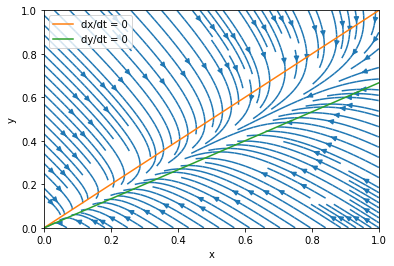

In [4]:
xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)
k_values = (2, 2, 1)

plot_ionic_streamplot(xs, ys, k_values)

## 4c

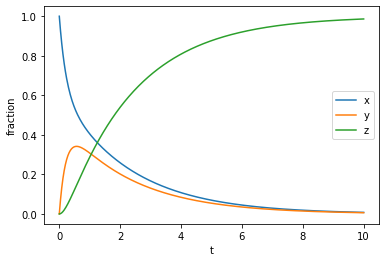

Final x: 0.0077468680112353135 
Final y: 0.006048573168351744 
Final z: 0.9862045588204121


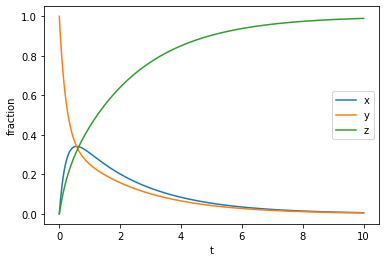

Final x: 0.006048547358510073 
Final y: 0.004722581885518055 
Final z: 0.9892288707559722


In [5]:
plot_ionic_over_time((1, 0, 0), (2, 2, 1), np.linspace(0, 10, 500))
plot_ionic_over_time((0, 1, 0), (2, 2, 1), np.linspace(0, 10, 500))

## 4f

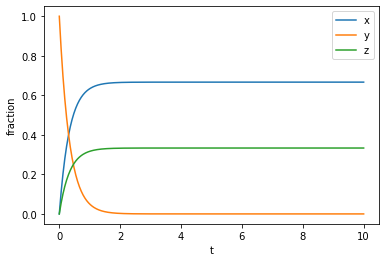

Final x: 0.6666666667337752 
Final y: -1.0066264305497948e-10 
Final z: 0.3333333333668876


In [6]:
plot_ionic_over_time((0, 1, 0), (0, 2, 1), np.linspace(0, 10, 500))

## 4j

In [7]:
print("For {k2, k3} = {2, 1}:")
print(f"Theoretical x* = {2/(2+1)}")
print(f"Theoretical z* = {1/(2+1)}")

For {k2, k3} = {2, 1}:
Theoretical x* = 0.6666666666666666
Theoretical z* = 0.3333333333333333
